In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import exists, expanduser

from src.skeleton_morphology import run_morphology_analysis
from src.connectome import Connectome
from src.utils import load_preprocessed_connectome, yymmdd_today
#from src.node_ops import segment_skeleton, find_end_points, find_central_segment, measure_path_lengths, measure_seg_distances
from vis.fig_tools import subtype_cm

plt.rcdefaults()
plt.style.use('vis/lamina.mplstyle')

In [3]:
tp = '200507'
C = load_preprocessed_connectome(f"~/Data/{tp}_lamina/")

Pickle loaded from: /mnt/home/nchua/Data/200507_lamina/200507_preprocessed.pickle


In [4]:
results_file = expanduser(f'~/Data/{tp}_lamina/210419_lmc-morphology.json')
lmc_sts = ['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4', 'LMC_N']#, 'LMC_3', 'LMC_4']#, 'LMC_N']#, 'R7', 'R8', 'R7p']
lmc_ids = [s for s, data in C.skel_data.items() if data.subtype in lmc_sts]

if exists(results_file):
    with open(results_file, 'r') as fh:
        d = json.load(fh)
        segments, central_segs, seg_lens, seg_dists, strahler = d['segments'], d['central_segs'], d['seg_lengths'], d['seg_distances'], d['strahler']
else:
    segments, central_segs, seg_lens, seg_dists, strahler = run_morphology_analysis(C, lmc_ids, 
                                                                                    restrict_tags='lamina_end', 
                                                                                    save_file=results_file, 
                                                                                    verbose=False)

In [5]:
summary = []
for s in lmc_ids:
    data = C.skel_data[s]
    
    summary.append({'name': data.name,
                    'skel_id': data.skel_id,
                    'om': data.group,
                    'subtype': data.subtype,
                    'n_central_nodes': len(central_segs[s]), 
                    'n_nodes': len(data.skel_nodes) - len(data.r_nodes), 
                    'n_segments': len(segments[s]),
                    'total_path_len': sum([v for k, v in seg_lens[s].items()]),
                    'strahler_num': max([v for k, v in strahler[s].items()])})
    
cell_df = pd.DataFrame(summary).set_index('skel_id')

In [45]:
seg_data = []
major_segs = []

def div(num: float, denom: float):
    if denom == 0:
        return np.nan
    else:
        return float(num)/float(denom)

for s, segmented in segments.items():
    for seg_ind, seg in segmented.items():
        if int(seg_ind) in central_segs[s]:  # seg_ind = seg[1]
            #print(f"skip {seg_ind}")
            continue
        #elif (int(seg[0]) in central_segs[s]) and strahler[s][str(seg[-1])] == 1:
        elif (int(seg[0]) in central_segs[s]) and (strahler[s][str(seg[-1])] == 1):
            continue  # exclude knobs, maybe also try a min length?
        else:
            strahl_ind = seg[-1]  
            # strahler[s] is indexed by last node of the segment  
            this_seg = {'skel_id': str(s),
                         'name': cell_df.loc[s, 'name'], 
                        'om': cell_df.loc[s, 'om'], 
                         'subtype': cell_df.loc[s, 'subtype'],
                         'ind': seg_ind,
                         'dist': seg_dists[s][seg_ind], 
                         'len': seg_lens[s][seg_ind],
                         'tortuosity': div(seg_lens[s][seg_ind], seg_dists[s][seg_ind]), 
                         'strahl_ord': strahler[s][str(strahl_ind)]}
            seg_data.append(this_seg)
            if int(seg[0]) in central_segs[s]:
                major_segs.append(this_seg)

seg_df = pd.DataFrame(seg_data)
major_df = pd.DataFrame(major_segs)

In [82]:
def subtree_total(current_ind, segs, seg_measurements, total=0.0):
    
    # branch index for the first and last node of the segment
    
    start = current_ind
    end = segs[str(start)][-1]  
    total += seg_measurements[str(start)] # get current segment's measurement
    next_inds = [int(k) for k, v in segs.items() if (v[0] == end)]
    if len(next_inds) == 0:
        return total
    else:
        for i in next_inds:
            total += subtree_total(i, segs, seg_measurements, total)
        return total
    

subtree_total_len = []
subtree_total_dist = []
for i, seg_data in major_df.iterrows():
    skel_id = seg_data['skel_id']
    these_segs = segments[skel_id]

    seg_ind = seg_data['ind']
    subtree_total_len.append(subtree_total(seg_ind, these_segs, seg_lens[skel_id]))
    subtree_total_dist.append(subtree_total(seg_ind, these_segs, seg_dists[skel_id]))
    
major_df['subtree_len'] = subtree_total_len
major_df['subtree_dist'] = subtree_total_dist
major_df['subtree_tortu'] = major_df['subtree_len'] / major_df['subtree_dist']

In [87]:
major_df['subtree_len'].min()

506.0653112180564

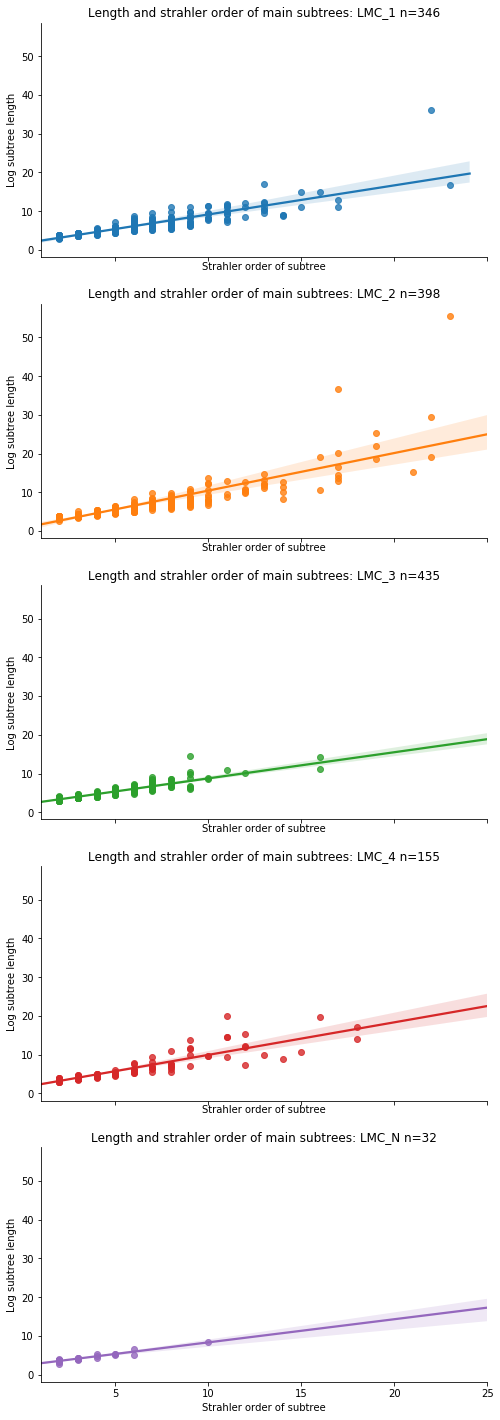

In [115]:
fig, axes = plt.subplots(5, sharex=True, sharey=True, figsize=[8, 25])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0

for st, seg in major_df.groupby('subtype'):

    xdata = seg['strahl_ord']
    ydata = np.log10(seg['subtree_len'])
        
    #axes[i].scatter(xdata, ydata)
    
    sns.regplot(x=xdata, y=ydata, ax=axes[i])
    #axes[i].set_yscale('log')
    axes[i].set_title(f"Length and strahler order of main subtrees: {st}"
                      + f" n={len(xdata)}")
    axes[i].set_xlabel('Strahler order of subtree')
    axes[i].set_ylabel('Log subtree length')
    axes[i].set_xlim([1, 25])
    
    #print(np.log10(seg['subtree_len'].max()))
    

    i += 1

(1, 23)

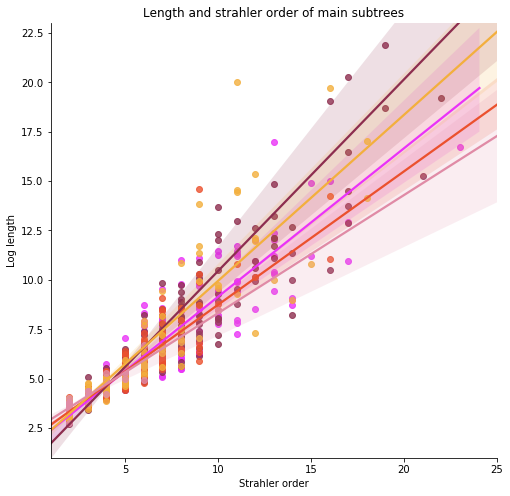

In [118]:
st_cm = subtype_cm()
fig, ax = plt.subplots(1, figsize=[8, 8])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0

for st, seg in major_df.groupby('subtype'):

    xdata = seg['strahl_ord']
    ydata = np.log10(seg['subtree_len'])
        
    #axes[i].scatter(xdata, ydata)
    #ax.set_yscale('log')
    sns.regplot(x=xdata, y=ydata, ax=ax, color=st_cm[st])
    i += 1
    
ax.set_title(f"Length and strahler order of main subtrees")
ax.set_xlabel('Strahler order')
ax.set_ylabel('Log length')
ax.set_xlim([1, 25])
ax.set_ylim([1, major_df['strahl_ord'].max()])
    



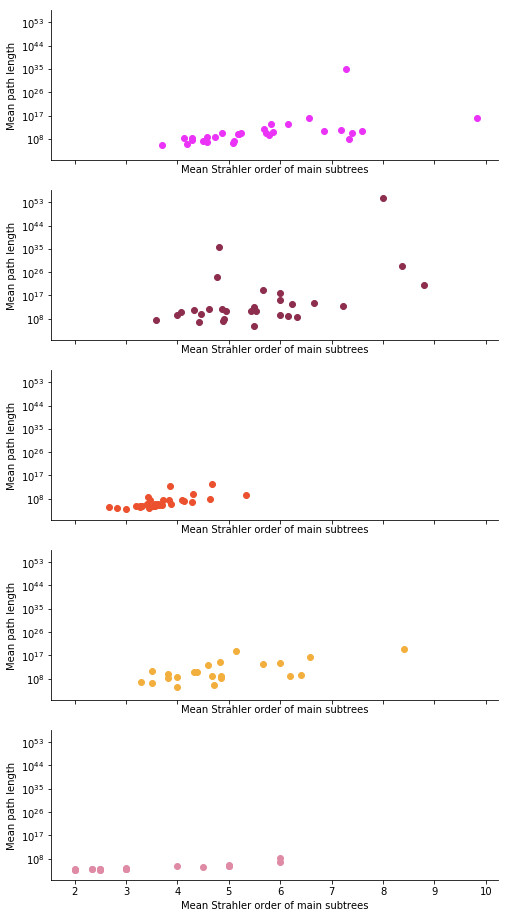

In [131]:
fig, axes = plt.subplots(5, sharex=True, sharey=True, figsize=[8, 16])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0

for st, seg in major_df.groupby('subtype'):
    xdata = []
    ydata = []
    for om, segseg in seg.groupby('om'):
        om_total = major_df.loc[major_df['om'] == om, 'subtree_len'].sum()
        xdata.append(segseg['strahl_ord'].mean())
        #print(segseg['subtree_len'].mean())
        ydata.append(segseg['subtree_len'].mean())
    ## try w/o log
    axes[i].set_yscale('log')    
    axes[i].scatter(xdata, ydata, c=st_cm[st])
    axes[i].set_xlabel('Mean Strahler order of main subtrees')
    axes[i].set_ylabel('Mean path length')
    

    i += 1

/mnt/home/nchua/miniconda3/envs/wasp/lib/python3.6/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/mnt/home/nchua/miniconda3/envs/wasp/lib/python3.6/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/mnt/home/nchua/miniconda3/envs/wasp/lib/python3.6/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/mnt/home/nchua/miniconda3/envs/wasp/lib/python3.6/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/mnt/home/nchua/miniconda3/envs/wasp/lib/python3.6/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


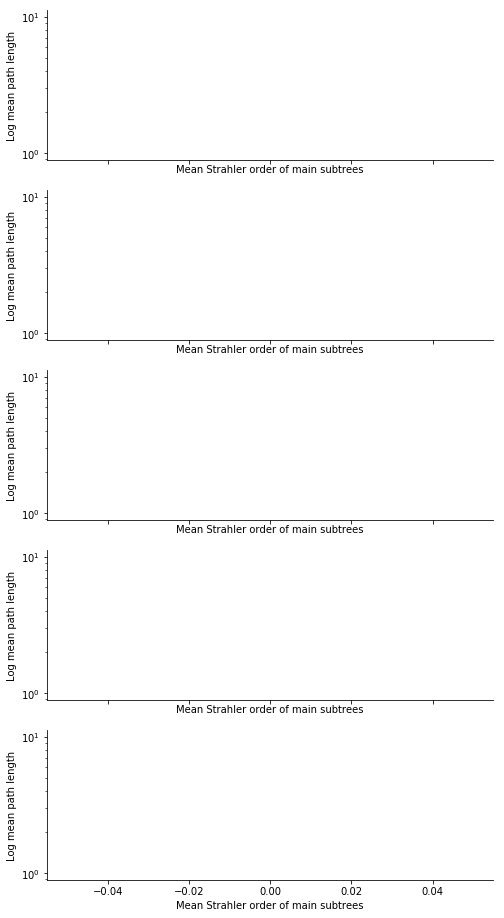

In [78]:
fig, axes = plt.subplots(5, sharex=True, sharey=True, figsize=[8, 16])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0

for st, seg in major_df.groupby('subtype'):
    xdata = []
    ydata = []
    for om, segseg in seg.groupby('om'):
        om_total = major_df.loc[major_df['om'] == om, 'subtree_len'].sum()
        xdata.append(segseg['strahl_ord'].mean())
        ydata.append(np.log10(segseg['subtree_len'].mean()/om_total))
    axes[i].set_yscale('log')    
    axes[i].scatter(xdata, ydata, c=st_cm[st])
    axes[i].set_xlabel('Mean Strahler order of main subtrees')
    axes[i].set_ylabel('Log mean path length')
    

    i += 1

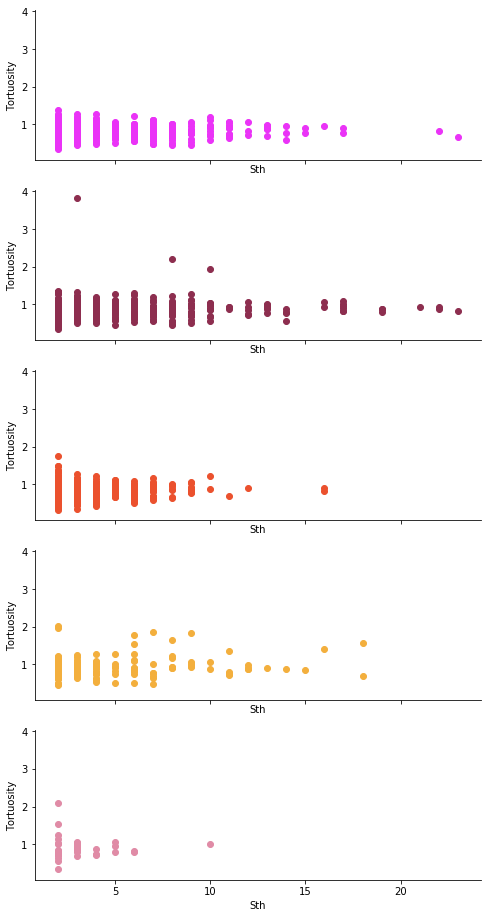

In [130]:
fig, ax = plt.subplots(5, sharex=True, sharey=True, figsize=[8, 16])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0

for st, seg in major_df.groupby('subtype'):
    xdata = seg['strahl_ord']
    ydata = seg['subtree_tortu']
    
    #axes[i].set_yscale('log')    
    ax[i].scatter(xdata, ydata, c=st_cm[st])

#ax.set_yscale('log')
    ax[i].set_xlabel('Sth')
    ax[i].set_ylabel('Tortuosity')
    i+=1
    



In [33]:
for subtype, subtrees in major_df.groupby('subtype'):
    
    
    print(subtrees['subtree_len'].mean())
    print(subtrees['subtree_len'].std())

2.866259932152011e+33
5.331551664887416e+34
6.304040402109354e+52
1.257652110314612e+54
1306126345667.762
20530020996749.125
9.683889945980404e+17
8.961881634102211e+18
9934380.941410024
55027249.03817193
